## NBA Career Prediction Experiment

In [1]:
experiment_label = 'rforest05a'

### Aim:

To revisit my earlier Random Forest, and attempt to improve it by applying Gausiian Mixture clusters, HyperOpt tuning and examiniation of partial dependece and LIME.
* Previous best Random Forest run was 'rforest03'.
* Kaggle test result of that was 0.70360.

To improve on the best result so far from the team, which was a polynomial logistic regression, with features set ['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV']

* Kaggle result to beat: 0.71259.


### Findings:
                                       
Results (05)
* train, val auc: 0.75, 0.70
* test Kaggle 0.70564
* this is a tiny improvement, and still way short of the results of our logreg, poly logreg and SVC work.


Results (05a) with Gaussian Mixture Clusters added as a feature:
* Training data 0.75
* Validation data 0.70
* Test data 0.70797
* this is another small improvement, but still well short of our best.


## Set up

In [58]:
import pandas as pd
import numpy as np
from joblib import dump, load  # simpler than pickle!
import matplotlib.pyplot as plt
import seaborn as sns

from src.common_lib import confusion_matrix, plot_roc, eval_report


## Data

In [4]:
#load data

data_path = '../data/raw'

train_raw = pd.read_csv(data_path + '/train.csv')
test_raw = pd.read_csv(data_path + '/test.csv')


In [5]:
#shapes & head

print(train_raw.shape)
print(test_raw.shape)

train_raw.head()

(8000, 22)
(3799, 21)


Id_old    Id  GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA  ...  FTA   FT%  \
0   10556  3799  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  ...  2.9  72.1   
1    5342  3800  75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  ...  3.6  67.8   
2    5716  3801  85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  ...  0.6  75.7   
3   13790  3802  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  ...  1.5  66.9   
4    5470  3803  63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  ...  0.5  54.0   

   OREB  DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0   2.2   2.0  3.8  3.2  1.1  0.2  1.6            1  
1   3.6   3.7  6.6  0.7  0.5  0.6  1.4            1  
2   0.6   1.8  2.4  0.8  0.4  0.2  0.6            1  
3   0.8   2.0  3.0  1.8  0.4  0.1  1.9            1  
4   2.4   2.7  4.9  0.4  0.4  0.6  0.7            1  

[5 rows x 22 columns]

In [6]:
test_raw.head()

Id_old  Id  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA  ...  FTM  FTA  \
0       1   0  56   9.1   4.0  1.6   3.7  43.7      0.1  0.3  ...  0.7  1.2   
1    8194   1  43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  ...  1.8  2.5   
2       3   2  82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  ...  1.8  2.7   
3    8196   3  86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  ...  4.5  6.3   
4    8197   4  58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  ...  1.1  1.3   

    FT%  OREB  DREB  REB  AST  STL  BLK  TOV  
0  63.4   1.2   0.8  1.7  0.4  0.2  0.3  0.8  
1  75.3   0.5   0.9  1.5  3.5  0.6  0.0  1.8  
2  71.2   1.3   3.3  4.5  2.5  1.3  0.3  2.0  
3  70.9   1.5   3.2  5.0  4.1  0.9  0.1  3.6  
4  76.9   0.2   0.6  0.9  1.5  0.5 -0.4  0.9  

[5 rows x 21 columns]

In [7]:
# info
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-null   float64
 19  BLK   

In [8]:
print(train_raw.where(train_raw < 0).count())

Id_old            0
Id                0
GP                2
MIN               0
PTS               0
FGM               0
FGA               0
FG%               0
3P Made        1629
3PA            1658
3P%             878
FTM               0
FTA               0
FT%               1
OREB              0
DREB              0
REB               0
AST               0
STL               0
BLK            1048
TOV               0
TARGET_5Yrs       0
dtype: int64


In [9]:
len(train_raw[(train_raw['3P%'] < 0) | (train_raw['3P Made'] < 0) | (train_raw['3PA'] < 0)])

2192

In [10]:
len(train_raw[(train_raw['3P%'] < 0) | (train_raw['3P Made'] < 0) | (train_raw['3PA'] < 0) | (train_raw['BLK'] < 0)])

3046

In [11]:
#variable descriptions
train_raw.describe()

Id_old           Id           GP          MIN          PTS  \
count   8000.000000   8000.00000  8000.000000  8000.000000  8000.000000   
mean    6856.971000   7798.50000    62.777875    18.576663     7.267087   
std     3977.447579   2309.54541    17.118774     8.935263     4.318732   
min        4.000000   3799.00000    -8.000000     2.900000     0.800000   
25%     3413.750000   5798.75000    51.000000    12.000000     4.100000   
50%     6787.500000   7798.50000    63.000000    16.800000     6.300000   
75%    10299.250000   9798.25000    74.000000    23.500000     9.500000   
max    13798.000000  11798.00000   123.000000    73.800000    34.200000   

               FGM          FGA          FG%      3P Made          3PA  ...  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000  ...   
mean      2.807037     6.231213    44.608900     0.264525     0.816563  ...   
std       1.693373     3.584559     6.155453     0.384093     1.060964  ...   
min       0.300000     0.800000    21.300000    -1.100000    -3.100000  ...   
25%       1.600000     3.600000    40.400000     0.000000     0.100000  ...   
50%       2.400000     5.400000    44.400000     0.300000     0.800000  ...   
75%       3.700000     8.100000    48.700000     0.500000     1.500000  ...   
max      13.100000    28.900000    67.200000     1.700000     4.700000  ...   

               FTA          FT%         OREB         DREB          REB  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean      1.947787    71.365825     1.077838     2.168500     3.245300   
std       1.252352    10.430447     0.785670     1.392224     2.085154   
min       0.000000   -13.300000     0.000000     0.200000     0.300000   
25%       1.000000    65.000000     0.500000     1.100000     1.700000   
50%       1.700000    71.400000     0.900000     1.900000     2.800000   
75%       2.600000    77.500000     1.500000     2.900000     4.300000   
max      11.100000   168.900000     5.500000    11.000000    15.900000   

               AST          STL          BLK          TOV  TARGET_5Yrs  
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000  
mean      1.624513     0.648688     0.245212     1.257762     0.833625  
std       1.355986     0.407626     0.821037     0.723270     0.372440  
min       0.000000     0.000000   -17.900000     0.100000     0.000000  
25%       0.700000     0.300000     0.100000     0.700000     1.000000  
50%       1.300000     0.600000     0.200000     1.100000     1.000000  
75%       2.200000     0.900000     0.400000     1.600000     1.000000  
max      12.800000     3.600000    18.900000     5.300000     1.000000  

[8 rows x 22 columns]

In [12]:
test_raw.describe()

Id_old           Id           GP          MIN          PTS  \
count   3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean    7010.614109  1899.000000    62.853909    18.650224     7.328034   
std     3954.173641  1096.821164    17.151740     8.727259     4.294724   
min        1.000000     0.000000     6.000000     3.700000     0.700000   
25%     3644.000000   949.500000    51.000000    12.200000     4.200000   
50%     7062.000000  1899.000000    63.000000    17.000000     6.400000   
75%    10402.500000  2848.500000    74.000000    23.300000     9.400000   
max    13792.000000  3798.000000   126.000000    68.000000    33.000000   

               FGM          FGA          FG%      3P Made          3PA  ...  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000  ...   
mean      2.835404     6.302580    44.599079     0.255962     0.796920  ...   
std       1.688427     3.579221     6.040168     0.380987     1.052862  ...   
min       0.300000     0.800000    25.100000    -1.000000    -2.700000  ...   
25%       1.600000     3.700000    40.500000     0.000000     0.100000  ...   
50%       2.500000     5.500000    44.600000     0.300000     0.800000  ...   
75%       3.700000     8.100000    48.500000     0.500000     1.500000  ...   
max      13.400000    26.200000    74.600000     1.600000     4.300000  ...   

               FTM          FTA          FT%         OREB         DREB  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean      1.399842     1.953567    71.612924     1.096025     2.179495   
std       0.926140     1.250376    10.457336     0.785678     1.371935   
min       0.000000     0.000000    23.700000     0.000000     0.200000   
25%       0.700000     1.000000    65.000000     0.500000     1.200000   
50%       1.200000     1.700000    71.500000     0.900000     1.900000   
75%       1.900000     2.600000    78.000000     1.500000     2.900000   
max       7.800000     9.800000   127.100000     6.900000    12.000000   

               REB          AST          STL          BLK          TOV  
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000  
mean      3.275783     1.636483     0.653593     0.257726     1.257910  
std       2.070646     1.335496     0.410573     0.639660     0.712449  
min       0.300000     0.000000     0.000000    -7.100000     0.100000  
25%       1.800000     0.600000     0.400000     0.100000     0.700000  
50%       2.800000     1.300000     0.600000     0.200000     1.100000  
75%       4.300000     2.300000     0.900000     0.400000     1.600000  
max      18.500000     9.000000     2.700000    14.800000     5.200000  

[8 rows x 21 columns]

## Decisions

We will retain all potential features, when using non-linear models.

We will set negative values to ABS(value); the numbers appear sensible but for the sign and there are over 3000 observations with one or more negatives.

and TARGET_5Yrs is our target.

## Cleaning

In [13]:
train = train_raw.copy()
test = test_raw.copy()

In [14]:
cols_drop = ['Id_old', 'Id'] #, 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

In [15]:
train.head()

GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
0  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  22.6  2.0  2.9  72.1   2.2   
1  75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  34.9  2.4  3.6  67.8   3.6   
2  85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  34.3  0.4  0.6  75.7   0.6   
3  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  23.7  0.9  1.5  66.9   0.8   
4  63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  13.7  0.2  0.5  54.0   2.4   

   DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0   2.0  3.8  3.2  1.1  0.2  1.6            1  
1   3.7  6.6  0.7  0.5  0.6  1.4            1  
2   1.8  2.4  0.8  0.4  0.2  0.6            1  
3   2.0  3.0  1.8  0.4  0.1  1.9            1  
4   2.7  4.9  0.4  0.4  0.6  0.7            1

In [16]:
test.head()

GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
0  56   9.1   4.0  1.6   3.7  43.7      0.1  0.3   7.3  0.7  1.2  63.4   1.2   
1  43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  35.1  1.8  2.5  75.3   0.5   
2  82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  44.8  1.8  2.7  71.2   1.3   
3  86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  13.5  4.5  6.3  70.9   1.5   
4  58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  38.7  1.1  1.3  76.9   0.2   

   DREB  REB  AST  STL  BLK  TOV  
0   0.8  1.7  0.4  0.2  0.3  0.8  
1   0.9  1.5  3.5  0.6  0.0  1.8  
2   3.3  4.5  2.5  1.3  0.3  2.0  
3   3.2  5.0  4.1  0.9  0.1  3.6  
4   0.6  0.9  1.5  0.5 -0.4  0.9

In [17]:
# Negative values do not make sense in this context

def clean_negatives(strategy, df):
    
    if strategy=='abs':
        df = abs(df)
    if strategy=='null':
        df[df < 0] = None
    if strategy=='mean':
        df[df < 0] = None
        df.fillna(df.mean(), inplace=True)     
    if strategy=='median':
        df[df < 0] = None
        df.fillna(df.median(), inplace=True)   
    
    return(df)


In [18]:
negatives_strategy = 'abs'

train = clean_negatives(negatives_strategy, train)
test = clean_negatives(negatives_strategy, test)


In [19]:
train.head()

GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
0  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  22.6  2.0  2.9  72.1   2.2   
1  75  21.8  10.5  4.2  7.9  55.1      0.3  1.0  34.9  2.4  3.6  67.8   3.6   
2  85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  34.3  0.4  0.6  75.7   0.6   
3  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  23.7  0.9  1.5  66.9   0.8   
4  63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  13.7  0.2  0.5  54.0   2.4   

   DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0   2.0  3.8  3.2  1.1  0.2  1.6            1  
1   3.7  6.6  0.7  0.5  0.6  1.4            1  
2   1.8  2.4  0.8  0.4  0.2  0.6            1  
3   2.0  3.0  1.8  0.4  0.1  1.9            1  
4   2.7  4.9  0.4  0.4  0.6  0.7            1

In [20]:
test.head()

GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
0  56   9.1   4.0  1.6   3.7  43.7      0.1  0.3   7.3  0.7  1.2  63.4   1.2   
1  43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  35.1  1.8  2.5  75.3   0.5   
2  82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  44.8  1.8  2.7  71.2   1.3   
3  86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  13.5  4.5  6.3  70.9   1.5   
4  58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  38.7  1.1  1.3  76.9   0.2   

   DREB  REB  AST  STL  BLK  TOV  
0   0.8  1.7  0.4  0.2  0.3  0.8  
1   0.9  1.5  3.5  0.6  0.0  1.8  
2   3.3  4.5  2.5  1.3  0.3  2.0  
3   3.2  5.0  4.1  0.9  0.1  3.6  
4   0.6  0.9  1.5  0.5  0.4  0.9

In [21]:
train_target = train.pop('TARGET_5Yrs')

In [22]:
#examine shapes

print('train:' + str(train.shape))
print('test:' + str(test.shape))

train:(8000, 19)
test:(3799, 19)


In [23]:
# target class balance check
from collections import Counter

counter = Counter(train_target)
print(counter)

Counter({1: 6669, 0: 1331})


## Scaling & splitting of data

In [24]:
#transformations

# scaling - not for tree-based model


In [25]:
# set training data and validation data

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=8)


## Feature engineering - Gaussian clusters

In [26]:
from sklearn.mixture import GaussianMixture

In [45]:
def optimal_gaussian_clusters(X, min, max):
    
    import numpy as np
    import itertools

    from scipy import linalg
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    from sklearn import mixture

    lowest_bic = np.infty
    bic = []
    n_components_range = range(min, max+1)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type,
                                         random_state=0)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the winner
    #splot = plt.subplot(2, 1, 2)
    #Y_ = clf.predict(X)
    #for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
    #                                           color_iter)):
    #    v, w = linalg.eigh(cov)
    #    if not np.any(Y_ == i):
    #        continue
    #    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
#        angle = np.arctan2(w[0][1], w[0][0])
#        angle = 180. * angle / np.pi  # convert to degrees
#        v = 2. * np.sqrt(2.) * np.sqrt(v)
#        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#        ell.set_clip_box(splot.bbox)
#        ell.set_alpha(.5)
#        splot.add_artist(ell)

#    plt.xticks(())
#    plt.yticks(())
#    plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
#              f'{best_gmm.n_components} components')
#    plt.subplots_adjust(hspace=.35, bottom=.02)
#    plt.show()
    

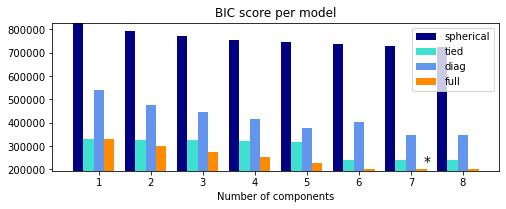

In [46]:
optimal_gaussian_clusters(X_train, 1, 8)

In [47]:
gm = GaussianMixture(n_components=7, 
                     covariance_type = 'full',  #{‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                     tol = 0.0001,
                     init_params = 'kmeans',  #{‘kmeans’, ‘random’}, default=’kmeans’
                     n_init = 1,
                     max_iter = 100,
                     random_state=8,
                    )

In [48]:
gm.fit(X_train)

GaussianMixture(n_components=7, random_state=8, tol=0.0001)

In [49]:
clusters_train = gm.predict(X_train)
clusters_val = gm.predict(X_val)
clusters_test = gm.predict(test)

### Decision about clusters:

Include as new feature.

In [50]:
X_train = X_train.assign(cluster = clusters_train)
X_val = X_val.assign(cluster = clusters_val)
test = test.assign(cluster = clusters_test)

In [51]:
X_train.head()

GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
3617  64  13.9  4.3  1.5  3.6  43.0      0.2  0.1  11.9  1.4  1.9  69.2   0.6   
1120  81  20.8  7.6  2.7  6.2  44.8      0.4  1.1  12.1  1.8  2.1  79.0   1.7   
3873  50   5.6  1.4  0.5  1.5  36.4      0.0  0.5   3.1  0.2  0.2  68.6   0.1   
153   72  19.3  5.0  2.0  5.0  40.4      0.1  0.5  25.3  0.9  1.6  48.4   0.7   
2960  45  19.7  6.1  2.5  5.9  42.1      0.1  0.4   2.7  1.1  1.7  62.0   1.0   

      DREB  REB  AST  STL  BLK  TOV  cluster  
3617   1.7  2.2  0.6  0.4  0.1  0.7        1  
1120   4.0  5.6  0.7  0.6  0.1  1.3        2  
3873   0.2  0.4  1.5  0.4  0.3  0.3        0  
153    2.0  2.9  1.1  0.5  0.2  0.9        3  
2960   1.5  2.6  1.5  0.4  0.3  1.8        3

In [52]:
# How do the clusters differ in career outcomes?

train_cluster_check = X_train.copy()

train_cluster_check = train_cluster_check.assign(target = y_train)
train_cluster_check.head()


GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  ...   FT%  OREB  \
3617  64  13.9  4.3  1.5  3.6  43.0      0.2  0.1  11.9  1.4  ...  69.2   0.6   
1120  81  20.8  7.6  2.7  6.2  44.8      0.4  1.1  12.1  1.8  ...  79.0   1.7   
3873  50   5.6  1.4  0.5  1.5  36.4      0.0  0.5   3.1  0.2  ...  68.6   0.1   
153   72  19.3  5.0  2.0  5.0  40.4      0.1  0.5  25.3  0.9  ...  48.4   0.7   
2960  45  19.7  6.1  2.5  5.9  42.1      0.1  0.4   2.7  1.1  ...  62.0   1.0   

      DREB  REB  AST  STL  BLK  TOV  cluster  target  
3617   1.7  2.2  0.6  0.4  0.1  0.7        1       1  
1120   4.0  5.6  0.7  0.6  0.1  1.3        2       1  
3873   0.2  0.4  1.5  0.4  0.3  0.3        0       1  
153    2.0  2.9  1.1  0.5  0.2  0.9        3       1  
2960   1.5  2.6  1.5  0.4  0.3  1.8        3       1  

[5 rows x 21 columns]

In [53]:
train_cluster_check.groupby(['cluster', 'target'])['GP'].count()


cluster  target
0        0          340
         1          917
1        0          149
         1         1049
2        0          159
         1         1383
3        0          313
         1         1459
4        0            5
         1           40
5        0           88
         1          194
6        0           20
         1          284
Name: GP, dtype: int64

# Modelling

In [54]:
# Define model

from sklearn.linear_model import LogisticRegressionCV

initial_model = LogisticRegressionCV(class_weight='balanced',
                             Cs=20,
                             max_iter=300,
                             penalty='l2',
                             scoring='roc_auc',
                             cv=6,
                             random_state=8)

In [55]:
# Fit model

initial_model.fit(X_train, y_train)


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegressionCV(Cs=20, class_weight='balanced', cv=6, max_iter=300,
                     random_state=8, scoring='roc_auc')

In [466]:
#dump(initial_model,  '../models/aj_' + experiment_label + '_initial.joblib')

In [56]:
y_train_preds = initial_model.predict(X_train)
y_val_preds = initial_model.predict(X_val)

Confusion Matrix:
        pred:0  pred:1
true:0     705     369
true:1    1926    3400

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.66      0.38      1074
           1       0.90      0.64      0.75      5326

    accuracy                           0.64      6400
   macro avg       0.59      0.65      0.56      6400
weighted avg       0.80      0.64      0.69      6400


ROC Curve:
AUC = 0.647


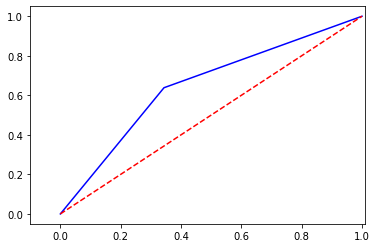

In [59]:
## Confusion matrix, metrics and AUC plot
eval_report(y_train, y_train_preds)


Confusion Matrix:
        pred:0  pred:1
true:0     174      83
true:1     506     837

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.68      0.37       257
           1       0.91      0.62      0.74      1343

    accuracy                           0.63      1600
   macro avg       0.58      0.65      0.56      1600
weighted avg       0.80      0.63      0.68      1600


ROC Curve:
AUC = 0.650


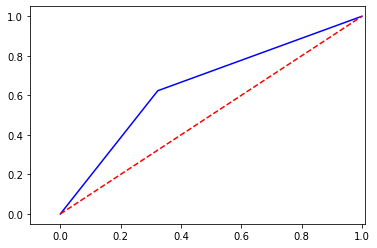

In [60]:
# model performance on validation data
eval_report(y_val, y_val_preds)

## Model tuning

In [61]:
# class imbalance pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline


In [173]:
#import models

#from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#from sklearn.model_selection import cross_val_score


In [174]:
# Define model
classifier = KNeighborsClassifier()

# Define parameters
param_grid = {
    'model__n_neighbors': [170, 180, 190],
    'over__sampling_strategy': [0.20, 0.25, 0.30],
    'under__sampling_strategy': [0.80, 0.85, 0.90]
}

# Define cv
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=8
)

# Define model pipeline
model = Pipeline([
        ('over', SMOTE()),    
        #('over', RandomOverSampler(sampling_strategy=0.25)),
        ('under', RandomUnderSampler()),
        ('model', classifier)
    ])

# Define grid search
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid, 
                    scoring='roc_auc', 
                    cv=cv,
                    verbose=1)


In [175]:
# Fit model

grid.fit(X_train, y_train)


Fitting 30 folds for each of 27 candidates, totalling 810 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=8),
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('under', RandomUnderSampler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [170, 180, 190],
                         'over__sampling_strategy': [0.2, 0.25, 0.3],
                         'under__sampling_strategy': [0.8, 0.85, 0.9]},
             scoring='roc_auc', verbose=1)

In [176]:
# can use this to get best result but doesn't actually do the fitting??

#scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#from numpy import mean
#print('Mean ROC AUC: %.3f' % mean(scores))

In [177]:
# Score of best model

mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__n_neighbors': 170, 'over__sampling_strategy': 0.25, 'under__sampling_strategy': 0.8}
Mean CV score:  0.694125
Standard deviation of CV score:  0.021674


In [178]:
#print(grid.cv_results_)

In [179]:
#save model to file

dump(grid,  '../models/aj_' + experiment_label + '_grid.joblib')

['../models/aj_knn03_grid.joblib']

In [180]:
### and here is where we take the best hyperparamters from the grid search and fit the model again.

# Define parameters
best_params = {k:[v] for k,v in grid.best_params_.items()}

# Hold out a validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=8)

# Best model
best = GridSearchCV(estimator=model,
                    param_grid=best_params, 
                    scoring='roc_auc', 
                    cv=cv,
                    verbose=1)

best.fit(X_train, y_train)


Fitting 30 folds for each of 1 candidates, totalling 30 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=8),
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('under', RandomUnderSampler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [170],
                         'over__sampling_strategy': [0.25],
                         'under__sampling_strategy': [0.8]},
             scoring='roc_auc', verbose=1)

In [189]:
dump(best,  '../models/aj_' + experiment_label + '_best.joblib')

['../models/aj_knn03_best.joblib']

In [190]:
#predictions for train & validation sets

y_train_preds = best.predict(X_train)
y_val_preds = best.predict(X_val)

## Fit best model

In [478]:
# here is where we take the best hyperparamters from the hyperparameter search and fit the model again.

forest_2 = RandomForestClassifier(class_weight='balanced',
    random_state=8,
    min_samples_leaf = int(best['min_samples_leaf']),
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth'])
)  

# Define model pipeline
best_model = Pipeline([
    #('over', SMOTE(sampling_strategy=0.5)),
    #('under', RandomUnderSampler(sampling_strategy=0.75)),
    ('model', forest_2)
])

best_model.fit(X_train, y_train)


Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=7, n_estimators=700,
                                        random_state=8))])

In [479]:
#save model to file

dump(best_model,  '../models/aj_' + experiment_label + '_best.joblib')

['../models/aj_rforest05a_best.joblib']

In [480]:
#predictions for train & validation sets

y_train_preds = best_model.predict(X_train)
y_val_preds = best_model.predict(X_val)

## Evaluation

In [481]:
# model performance on training data

eval_report(X_train, y_train, y_train_preds)

Confusion matrix:
          pred:0.0  pred:1.0
true:0.0       717       357
true:1.0      1611      3715

              precision    recall  f1-score   support

         0.0       0.31      0.67      0.42      1074
         1.0       0.91      0.70      0.79      5326

    accuracy                           0.69      6400
   macro avg       0.61      0.68      0.61      6400
weighted avg       0.81      0.69      0.73      6400


ROC AUC: 0.6826


In [482]:
# model performance on validation data

eval_report(X_val, y_val, y_val_preds)

Confusion matrix:
          pred:0.0  pred:1.0
true:0.0       155       102
true:1.0       445       898

              precision    recall  f1-score   support

         0.0       0.26      0.60      0.36       257
         1.0       0.90      0.67      0.77      1343

    accuracy                           0.66      1600
   macro avg       0.58      0.64      0.56      1600
weighted avg       0.80      0.66      0.70      1600


ROC AUC: 0.6359


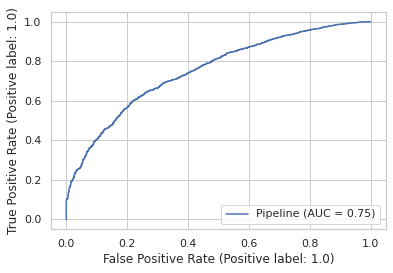

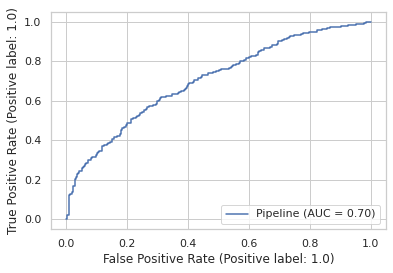

In [483]:
# ROC curves

import matplotlib.pyplot as plt  
from sklearn import metrics
metrics.plot_roc_curve(best_model, X_train, y_train)
plt.show() 
metrics.plot_roc_curve(best_model, X_val, y_val)
plt.show() 

## Variable importance by permutation


In [484]:
from sklearn.inspection import permutation_importance

In [485]:
r = permutation_importance(
    best_model, X_train, y_train,
    n_repeats=30,
    random_state=8
)

In [486]:
for i in r.importances_mean.argsort()[::-1]:
     print(f"{X_train.columns[i]}: {r.importances_mean[i]:.5f}")

FG%: 0.00742
FT%: 0.00427
FGA: 0.00265
3P%: 0.00195
GP: 0.00177
3PA: 0.00117
TOV: 0.00100
3P Made: 0.00093
BLK: -0.00004
FTM: -0.00063
AST: -0.00071
STL: -0.00089
FTA: -0.00154
cluster: -0.00190
DREB: -0.00355
FGM: -0.00427
PTS: -0.00441
OREB: -0.00651
MIN: -0.00671
REB: -0.00745


## Partial dependence plot

In [487]:
from sklearn.inspection import plot_partial_dependence

In [488]:
def plot_pdp(model, X, feature_name, feature_cols, target_classes):
    
    feature_index = feature_cols.get_loc(feature_name)
    
    print(f"PDP for `{feature_cols[feature_index]}` with {target_classes}")
    
    for target_class in target_classes:
        plot_partial_dependence(model, X, features=[feature_index], target=target_class)

In [489]:
target_classes=[1]

PDP for `FG%` with [1]
PDP for `FT%` with [1]
PDP for `FGA` with [1]
PDP for `3P%` with [1]
PDP for `GP` with [1]
PDP for `3PA` with [1]
PDP for `TOV` with [1]
PDP for `3P Made` with [1]


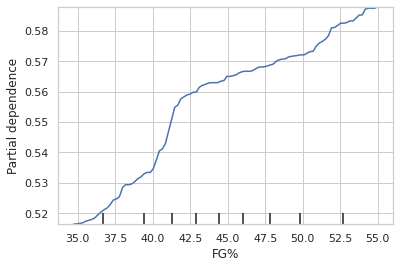

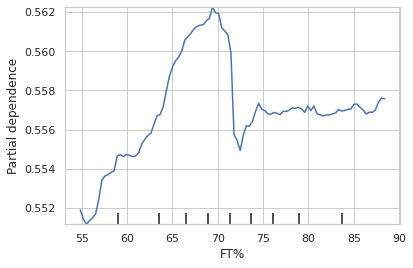

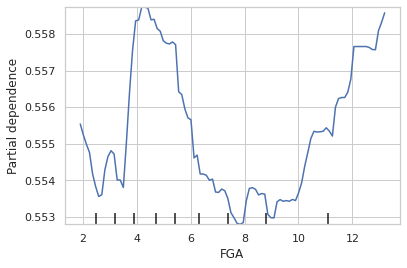

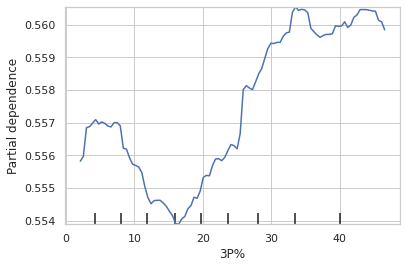

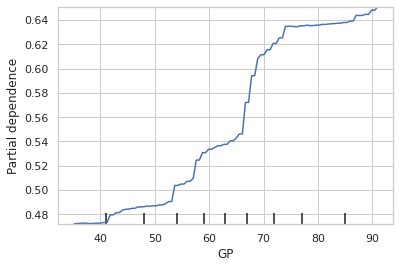

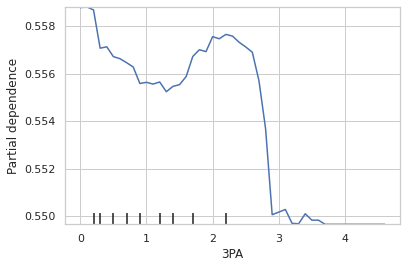

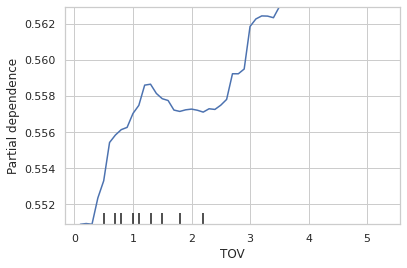

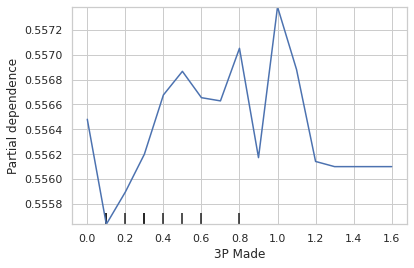

In [491]:
features = ['FG%', 'FT%', 'FGA', '3P%', 'GP', '3PA', 'TOV', '3P Made']

for f in features:
    plot_pdp(model=best_model, X=X_train, feature_name=f, feature_cols=X_train.columns, target_classes=target_classes)

## Explain specific observations with LIME

In [492]:
# compare proba and truth, for the validation data

y_val_proba = best_model.predict_proba(X_val)
val_inspection = pd.DataFrame(y_val_proba)
val_inspection['index'] = X_val.index
val_inspection.set_index('index', inplace = True)

y_val_frame = pd.DataFrame(y_val)
val_inspection['truth'] = y_val_frame

val_inspection.names()

val_inspection.head()

0         1  truth
index                           
5297   0.658509  0.341491    0.0
7323   0.589780  0.410220    1.0
7448   0.293089  0.706911    1.0
1627   0.411686  0.588314    1.0
659    0.584031  0.415969    1.0

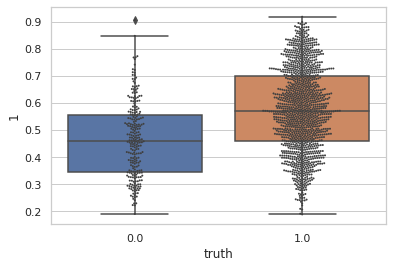

In [493]:
# compare proba vs truth

import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="truth", y=1, data=val_inspection)
ax = sns.swarmplot(x="truth", y=1, data=val_inspection, color='0.25', size=2)


In [494]:
# Sample the false negatives that are slightly off

val_inspection[(val_inspection['truth']== 1) & (val_inspection[1] < 0.5) & (val_inspection[1] > 0.4)].head(20)

0         1  truth
index                           
7323   0.589780  0.410220    1.0
659    0.584031  0.415969    1.0
4490   0.516365  0.483635    1.0
2942   0.597336  0.402664    1.0
7594   0.549899  0.450101    1.0
6472   0.510698  0.489302    1.0
4395   0.516799  0.483201    1.0
4354   0.525955  0.474045    1.0
3487   0.542009  0.457991    1.0
3386   0.504058  0.495942    1.0
1026   0.550447  0.449553    1.0
2672   0.518803  0.481197    1.0
4036   0.515856  0.484144    1.0
1296   0.516841  0.483159    1.0
7644   0.593967  0.406033    1.0
2636   0.538891  0.461109    1.0
2601   0.564386  0.435614    1.0
6809   0.555442  0.444558    1.0
1550   0.530898  0.469102    1.0
6380   0.504667  0.495333    1.0

In [495]:
# Sample the false negatives that are WAYYY off

val_inspection[(val_inspection['truth']== 1) & (val_inspection[1] < 0.25) ].head(20)

0         1  truth
index                           
4428   0.777921  0.222079    1.0
5928   0.757701  0.242299    1.0
2051   0.808217  0.191783    1.0
1169   0.759586  0.240414    1.0
7745   0.770505  0.229495    1.0
5635   0.756447  0.243553    1.0
4207   0.758316  0.241684    1.0
5214   0.811024  0.188976    1.0
5876   0.790453  0.209547    1.0
6121   0.764443  0.235557    1.0
839    0.792861  0.207139    1.0
6601   0.755267  0.244733    1.0
6559   0.750167  0.249833    1.0
2499   0.759435  0.240565    1.0
246    0.750650  0.249350    1.0

In [496]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_train,
      feature_names=X_train.columns,
      class_names=[0,1],
      mode='classification',
      discretize_continuous=False
)

In [497]:
def please_explain(model, X, obs):
    
    exp = lime_explainer.explain_instance(
        X.loc[obs], 
        model.predict_proba, 
        top_labels=1,
        num_features=20)
    exp.show_in_notebook()
    

In [498]:
please_explain(best_model, X_val, 7323)


In [499]:
please_explain(best_model, X_val, 659)


In [500]:
please_explain(best_model, X_val, 4428)


### Hypothesis to test: Feature "GP" might be behind many false negatives, so would the model be improved without it?

# Apply to test data for submission

In [501]:
y_test_preds = best_model.predict(test)


In [502]:
y_test_probs = best_model.predict_proba(test)

In [503]:
submission = pd.DataFrame({'Id': test.index, 'TARGET_5Yrs': [p[1] for p in y_test_probs]})

In [504]:
submission.head()

Id  TARGET_5Yrs
0   0     0.434796
1   1     0.470601
2   2     0.773950
3   3     0.837292
4   4     0.425006

In [505]:
submission.to_csv('../reports/aj_' + experiment_label + 'submission.csv',
                 index=False,
                 )

In [506]:
print(test)

        GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  \
0     56.0   9.1   4.0  1.6   3.7  43.7      0.1  0.3   7.3  0.7  1.2  63.4   
1     43.0  19.3  10.1  3.7   8.1  46.0      0.6  1.7  35.1  1.8  2.5  75.3   
2     82.0  33.9  11.3  4.9  10.6  45.6      0.5  1.9  44.8  1.8  2.7  71.2   
3     86.0  44.7  18.8  6.8  15.9  42.9      0.5  1.8  13.5  4.5  6.3  70.9   
4     58.0  12.3   4.7  1.6   4.0  40.0      0.5  1.7  38.7  1.1  1.3  76.9   
...    ...   ...   ...  ...   ...   ...      ...  ...   ...  ...  ...   ...   
3794  84.0  21.2   8.7  3.4   6.7  50.2      0.0  0.0   4.5  1.7  2.5  68.1   
3795  49.0  16.3   6.4  2.9   6.6  44.4      0.1  0.4  19.8  1.0  1.9  50.2   
3796  53.0   9.9   2.1  0.8   1.8  43.1      0.4  0.6   1.9  0.6  1.0  63.9   
3797  89.0  38.3  14.5  5.4  11.8  45.2      0.5  1.2  24.7  2.5  2.9  89.2   
3798  55.0  12.0   3.0  1.1   2.5  42.3      0.1  0.6  11.7  0.9  1.1  76.7   

      OREB  DREB  REB  AST  STL  BLK  TOV  cluster 

In [507]:
print(submission)

        Id  TARGET_5Yrs
0        0     0.434796
1        1     0.470601
2        2     0.773950
3        3     0.837292
4        4     0.425006
...    ...          ...
3794  3794     0.772780
3795  3795     0.521857
3796  3796     0.365514
3797  3797     0.764877
3798  3798     0.457614

[3799 rows x 2 columns]


In [508]:
print(X_val)

        GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  \
5297  42.0   7.4   2.6  1.0   2.1  46.9      0.1  0.3  24.6  0.4  0.5  81.2   
7323  59.0  12.6   2.8  1.3   3.2  41.2      0.2  0.4   3.4  0.1  0.3  62.6   
7448  70.0  16.1  13.1  5.3  11.2  47.7      0.2  0.7  16.2  2.4  3.3  76.1   
1627  48.0  20.4   9.5  3.8   6.4  60.0      0.1  0.3   5.6  1.8  2.7  60.8   
659   62.0  14.6   3.5  1.3   4.0  33.5      0.6  1.8  29.0  0.4  0.4  80.5   
...    ...   ...   ...  ...   ...   ...      ...  ...   ...  ...  ...   ...   
3474  49.0   5.0   1.6  0.6   1.5  46.8      0.3  0.5   0.5  0.3  0.5  63.7   
469   77.0  15.2   5.7  2.4   5.1  48.2      0.0  0.4  14.7  0.8  1.2  63.9   
6921  67.0  23.8  10.1  3.7   6.3  60.1      0.1  0.0  25.9  2.7  4.1  62.1   
3878  44.0  20.2   7.3  2.7   6.4  41.7      0.3  0.8   6.6  1.1  1.5  73.6   
7607  79.0  28.5  14.6  5.2  12.6  41.4      0.4  1.3   6.3  4.6  5.5  97.7   

      OREB  DREB  REB  AST  STL  BLK  TOV  cluster 